Conv2d -> Conv1d (channels EEG as channels)  
RNN?  
Классификация на основании разности состояний?  
Isolation forest поиск аномалий, кластеризация (DBScan), oneclass SVM (4/11 lecture), catboost - важность объектов  
Целевые эпохи как аномалии


In [31]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

In [32]:
# ML stuff
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline

In [33]:
# Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [34]:
from eeg_dataset_utils import *

In [35]:
def cross_validation(x, y, model_, result=False):
    
    cv = StratifiedKFold(random_state=42, shuffle=True)
    scores = []
    
    for train_index, test_index in cv.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        scaler = RobustScaler()
        scaler.fit(x_train_fold)
        x_train_norm = scaler.transform(x_train_fold)
        x_test_norm = scaler.transform(x_test_fold)

        model = model_    
        model.fit(x_train_norm, y_train_fold)
        scores.append(model.score(x_test_norm, y_test_fold))
    
    if result:
        return scores
    
    print('Accuray: '+', '.join([str(round(i, 2)) for i in scores]))
    
    

In [36]:
from collections import Counter

def sampling(dataset:EEGDataset=None, X:np.ndarray=None, y:np.ndarray=None,
             report=False, mode:list=None):
    '''
    
    mode -- 'real', 'over', 'under', 'balanced'
    '''
    
    if dataset:
        X = flatten(dataset.x.copy()) if len(dataset.x.shape)>2 else dataset.x.copy() # to flatten channels dim
        y = dataset.y.copy()
    else:
        X = flatten(X.copy()) if len(X.shape)>2 else X.copy()
        y = y.copy()
    count = Counter(y)
    if report:
        print(f'x shape: {X.shape}\ny shape: {y.shape}')
        print(f'class ratio: target={count[0]}, non-target={count[1]}')
    
    mode = mode if mode else ['real','over', 'under', 'balanced']
    
    data = dict.fromkeys(mode)
    
    if 'real' in mode:
        data['real']={'x':X, 'y':y}
    
    # Make downsampling
    if 'under' in mode:
        n_target = count[0]
        y_down = np.hstack([y[y==0], y[y==1][:n_target]])
        X_down = np.vstack([X[y==0], X[y==1][:n_target]])
        data['under'] = {'x':X_down, 'y':y_down}
        count = Counter(y_down)
        if report:
            print(f'x downsampled shape: {X_down.shape}\ny downsampled shape: {y_down.shape}')
            print(f'class ratio (downsampled): target={count[0]}, non-target={count[1]}')
    
    # Make oversampling
    if 'over' in mode:
        oversamler = SMOTE()
        X_over, y_over = oversamler.fit_resample(X, y)
        data['over'] = {'x':X_over, 'y':y_over}
        count = Counter(y_over)
        if report:
            print(f'x oversampled shape: {X_over.shape}\ny oversampled shape: {y_over.shape}')
            print(f'class ratio (oversampled): target={count[0]}, non-target={count[1]}')
    
    # Oversampling of minor class and undersampling of major class
    if 'balanced' in mode:
        over = SMOTE(sampling_strategy=0.5)
        under = RandomUnderSampler(sampling_strategy=0.5)
        pipe = ImbPipeline(steps=[('over', over), ('under', under)])
        X_balanced, y_balanced = pipe.fit_resample(X,y)
        data['balanced'] = {'x':X_balanced, 'y':y_balanced}
        count = Counter(y_balanced)
        if report:
            print(f'x balanced shape: {X_over.shape}\ny balanced shape: {y_over.shape}')
            print(f'class ratio (balanced): target={count[0]}, non-target={count[1]}')
    
    return data

# Подбор параметров для SVM

In [37]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])
X = dataset.x.copy()
y = dataset.y.copy()
c = Counter(y)
print(c)

Counter({1: 3199, 0: 400})


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('Train size:', Counter(y_train))
print('Test size:', Counter(y_test))

Train size: Counter({1: 2155, 0: 256})
Test size: Counter({1: 1044, 0: 144})


In [39]:
data = sampling(X=X_train, y=y_train, report=True)

x shape: (2411, 301)
y shape: (2411,)
class ratio: target=256, non-target=2155
x downsampled shape: (512, 301)
y downsampled shape: (512,)
class ratio (downsampled): target=256, non-target=256
x oversampled shape: (4310, 301)
y oversampled shape: (4310,)
class ratio (oversampled): target=2155, non-target=2155
x balanced shape: (4310, 301)
y balanced shape: (4310,)
class ratio (balanced): target=1077, non-target=2154


In [ ]:
from sklearn.model_selection import GridSearchCV
svc = SVC(random_state=42)
params = {'C':(1, 10, 100),
          'kernel':('linear', 'poly', 'rbf', 'sigmoid')}
search = GridSearchCV(svc, params, scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted', 'precision', 'recall'], refit=False)

search.fit(data['balanced']['x'], data['balanced']['y'])

In [ ]:
res = search.cv_results_
df = pd.DataFrame({'kernel':res['param_kernel'].data,
                   'C':res['param_C'].data,
                   'accuracy':res['mean_test_accuracy'],
                   'f1':res['mean_test_f1'],
                   'balanced_accuracy': res['mean_test_balanced_accuracy'],
                   'f1_weighted': res['mean_test_f1_weighted'],
                   'precision': res['mean_test_precision'],
                   'recall': res['mean_test_recall']})

In [ ]:
df.C = df.C.astype(dtype=str)
df.C.dtype

dtype('O')

In [ ]:
df = df.melt(id_vars=['kernel', 'C'], var_name='metric')
df.head(10)

,kernel,C,metric,value
0,linear,1,accuracy,0.666667
1,poly,1,accuracy,0.739079
2,rbf,1,accuracy,0.831337
3,sigmoid,1,accuracy,0.579078
4,linear,10,accuracy,0.666667
5,poly,10,accuracy,0.822339
6,rbf,10,accuracy,0.933774
7,sigmoid,10,accuracy,0.577530
8,linear,100,accuracy,0.666667
9,poly,100,accuracy,0.822967


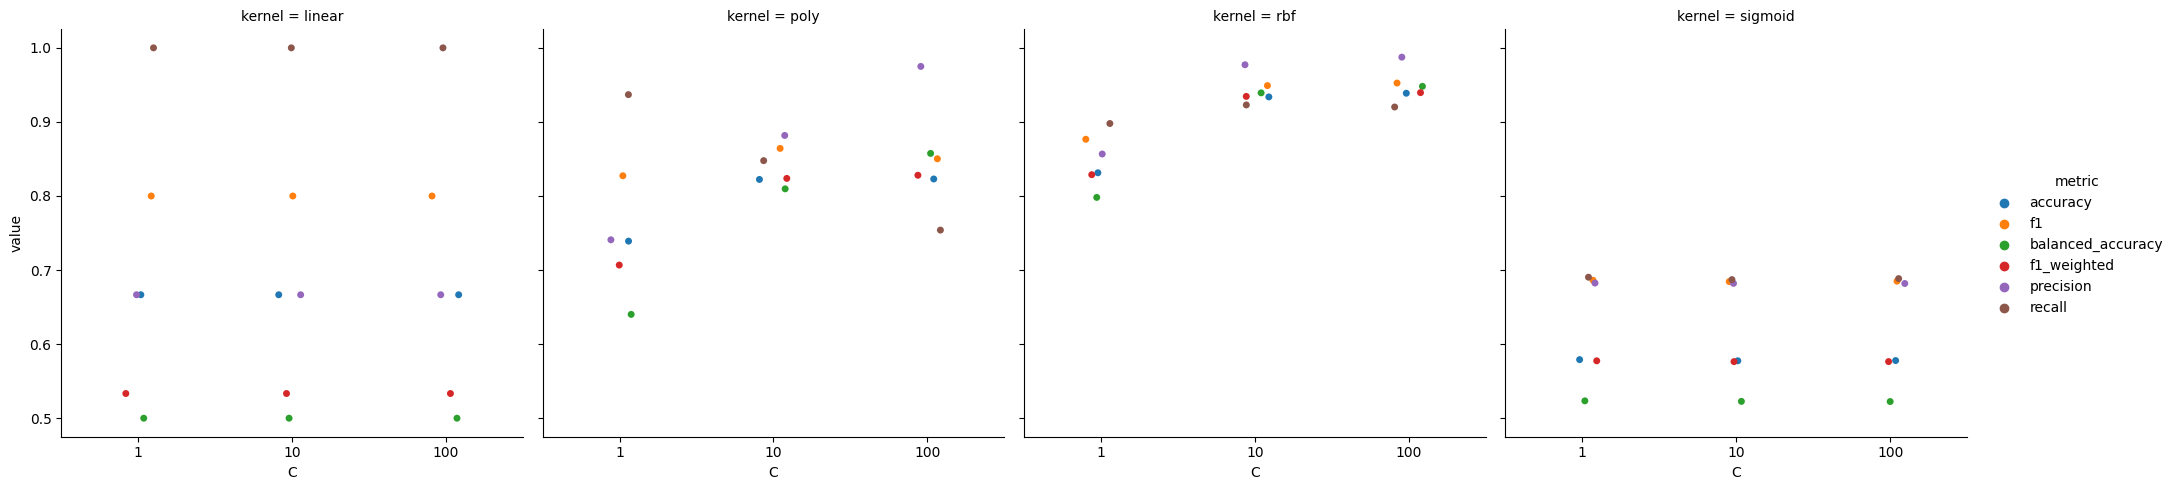

In [ ]:
g = sns.catplot(df, x='C', y='value', col='kernel', hue='metric')

Наилучший результат получается при использовании ядра rbf и параметра регуляризации 10

## LDA и SVM на данных одного испытуемого

In [110]:
def pipeline(X, y, *models, models_names:list=None, scoring:list=['accuracy'],
             test_size=0.3, scaler=None, sampling_mode:list=None):

    names = models_names if models_names else [*range(len(models))]
    assert len(names)==len(models), 'Number of names must be the same as the number of models'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    if scaler:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    data = sampling(X=X_train, y=y_train, mode=sampling_mode)
    
    result = []
    
    for sampl, train_set in data.items():
        models_list = list(models).copy()
        for name, model in zip(models_names, models_list):
            model.fit(train_set['x'], train_set['y'])
            y_pred = model.predict(X_test)
            res = get_scores(y_test, y_pred, scoring)
            res.update({'model':name,'sampling':sampl})
            result.append(pd.Series(res))
    
    return pd.DataFrame(result)
            

def get_scores(y_true, y_pred, scoring=None):
        
    metrics = {
        'accuracy': accuracy_score,
        'balanced_accuracy': balanced_accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }
    
    scoring = scoring if scoring else list(metrics.keys())
    
    scores = dict.fromkeys(scoring)
    
    for k, v in scores.items():
        scores[k] = metrics[k](y_true, y_pred)
        
    return scores
    
        

In [ ]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [ ]:
svm = SVC(C=10, kernel='rbf', random_state=42)
lda = LDA()
res = pipeline(X, y, svm, lda, models_names=['SVM', 'LDA'], scaler=RobustScaler(),
               sampling_mode=['real','balanced', 'over'], scoring=['accuracy','balanced_accuracy', 'f1', 'precision', 'recall'])

In [ ]:
res

,accuracy,balanced_accuracy,f1,precision,recall,model,sampling
0,0.876852,0.529099,0.933732,0.898370,0.971992,SVM,real
1,0.891667,0.518440,0.942450,0.896165,0.993776,LDA,real
2,0.840741,0.535413,0.911975,0.900000,0.924274,SVM,balanced
3,0.804630,0.583435,0.887706,0.911475,0.865145,LDA,balanced
4,0.831481,0.522643,0.906571,0.897358,0.915975,SVM,over
5,0.644444,0.622621,0.765568,0.930267,0.650415,LDA,over


In [ ]:
df = res.melt(id_vars=['model', 'sampling'], var_name='metric')
df.head()

,model,sampling,metric,value
0,SVM,real,accuracy,0.876852
1,LDA,real,accuracy,0.891667
2,SVM,balanced,accuracy,0.840741
3,LDA,balanced,accuracy,0.804630
4,SVM,over,accuracy,0.831481


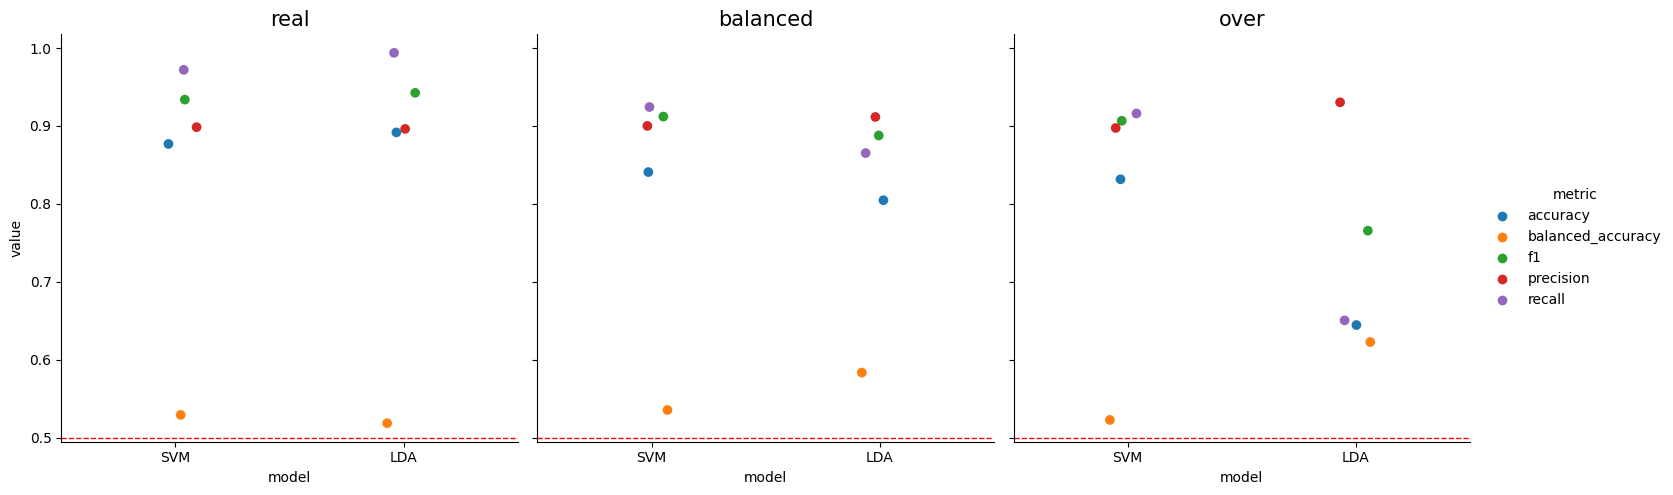

In [ ]:
# sns.scatterplot(df, s=60)
# g = sns.FacetGrid(df, col='sampling', hue='metric')
# g = (g.map(sns.catplot).add_legend())
# plt.show()
g = sns.catplot(df, x='model', y='value', hue='metric', col='sampling', size=7)
g.set_titles('{col_name}', size=15)
for ax in g.axes[0]:
    ax.axhline(0.5, ls='--', c='r', lw=1)
plt.show()

## Конфигурации элкетродов

In [41]:
# Порядок электродов
from ast import literal_eval
with open('./P300BCI_DataSet/eeg_ch_names.txt', 'r') as f:
    chnames = literal_eval(f.readline())
print(chnames)

['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'POz', 'PO4', 'O1', 'O2']


In [42]:
# Наборы каналов
ch_set1 = ['Pz']
ch_set3 = ['Pz', 'Cz', 'POz']
ch_set7 = ['Pz', 'Cz', 'POz', 'P3', 'P4', 'PO3', 'PO4']
ch_set9 = ['Cz', 'Pz', 'POz', 'P3', 'P4', 'P7', 'P8', 'PO3', 'PO4']
ch_set13 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4']
ch_set15 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']

In [46]:
# Создадим маски для отбора отдельных каналов данных
# NOTE: это не актуальный формат анализа
# mask1 = [chnames.index(ch) for ch in ['Pz']]
# mask3 = [chnames.index(ch) for ch in ['Pz', 'Cz', 'POz']]
# mask7 = [chnames.index(ch) for ch in ['Pz', 'Cz', 'POz', 'P3', 'P4', 'PO3', 'PO4']]
# mask9 = [chnames.index(ch) for ch in ['Cz', 'Pz', 'POz', 'P3', 'P4', 'P7', 'P8', 'PO3', 'PO4']]
# mask13 = [chnames.index(ch) for ch in ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4']]
# mask15 = [chnames.index(ch) for ch in ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']]
# masks = list(map(sorted, [mask1, mask3, mask7, mask9, mask13, mask15]))
# masks

[[34],
 [19, 34, 40],
 [19, 32, 34, 36, 39, 40, 41],
 [19, 30, 32, 34, 36, 38, 39, 40, 41],
 [19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 [19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]]

In [53]:
dataset.x.shape

(3599, 1, 301)

In [64]:
results = []
lda = LDA()
svm = SVC(kernel='rbf', C=10, random_state=42)
svmb = SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced')
for group in tqdm([ch_set1, ch_set3, ch_set7, ch_set9, ch_set13, ch_set15]):
    
    dataset.pick_channels(group)
    X = flatten(dataset.x.copy())
    y = dataset.y.copy()
    
    results.append(pipeline(X, y, lda, svmb, svm, models_names=['LDA', 'SVMb', 'SVM'],
                            scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'],
                            test_size=0.33, scaler=RobustScaler()))        

100%|██████████| 6/6 [00:19<00:00,  3.25s/it]


In [65]:
results[0].head()

,accuracy,balanced_accuracy,f1,precision,recall,model,sampling
0,0.609428,0.590722,0.737557,0.922207,0.614515,LDA,under
1,0.569865,0.561641,0.703768,0.914157,0.572102,SVMb,under
2,0.569865,0.561641,0.703768,0.914157,0.572102,SVM,under


In [66]:
dfs = []
for n_ch, res in zip([1,3,7,9,13,15], results):
    dfs.append(res.melt(id_vars=['model', 'sampling'], var_name='metric').assign(n_channels=n_ch))
df = pd.concat(dfs)

In [58]:
df.head(10)

,model,sampling,metric,value,n_channels
0,LDA,real,accuracy,0.882997,1
1,SVMb,real,accuracy,0.828283,1
2,SVM,real,accuracy,0.878788,1
3,LDA,balanced,accuracy,0.792088,1
4,SVMb,balanced,accuracy,0.827441,1
5,SVM,balanced,accuracy,0.840067,1
6,LDA,over,accuracy,0.636364,1
7,SVMb,over,accuracy,0.829966,1
8,SVM,over,accuracy,0.829966,1
9,LDA,real,balanced_accuracy,0.502903,1


In [61]:
# df.to_csv('./P300BCI_DataSet/n_channels_comparsion2.csv')
# df = pd.read_csv('./n_channels_comparsion.csv', index_col=0)
# df.head()

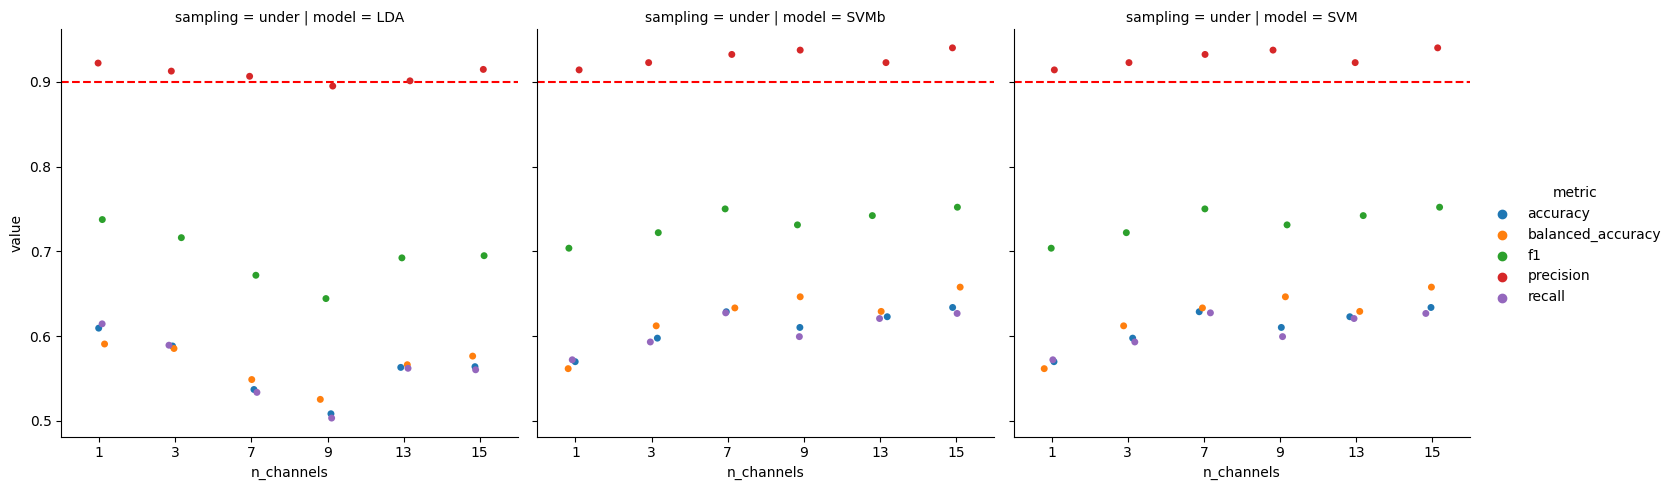

In [67]:
g = sns.catplot(df, x='n_channels', y='value', col='model', row='sampling', hue='metric')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    # ax.set_xticks(np.arange(1,16))

## Влияние усреднениея эпох

In [68]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])

In [70]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

ns = []
results = []

lda = LDA()
svm = SVC(kernel='rbf', C=10, random_state=42)
svmb = SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced')

for n in tqdm(range(1,11)):
    
    dataset.average(n)
    X = flatten(dataset.x.copy())
    y = dataset.y.copy()
    
    res = pipeline(X, y, lda, svmb, svm, models_names=['LDA', 'SVMb', 'SVM'],
                   scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'],
                   test_size=0.33, scaler=RobustScaler())
    ns.append(n)
    results.append(res)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


In [71]:
dfs = []
for n, res in zip(ns, results):
    dfs.append(res.melt(id_vars=['model', 'sampling'], var_name='metric').assign(n_epochs=n))
df = pd.concat(dfs)

In [72]:
# df.to_csv('n_epochs_comparsion2.csv')

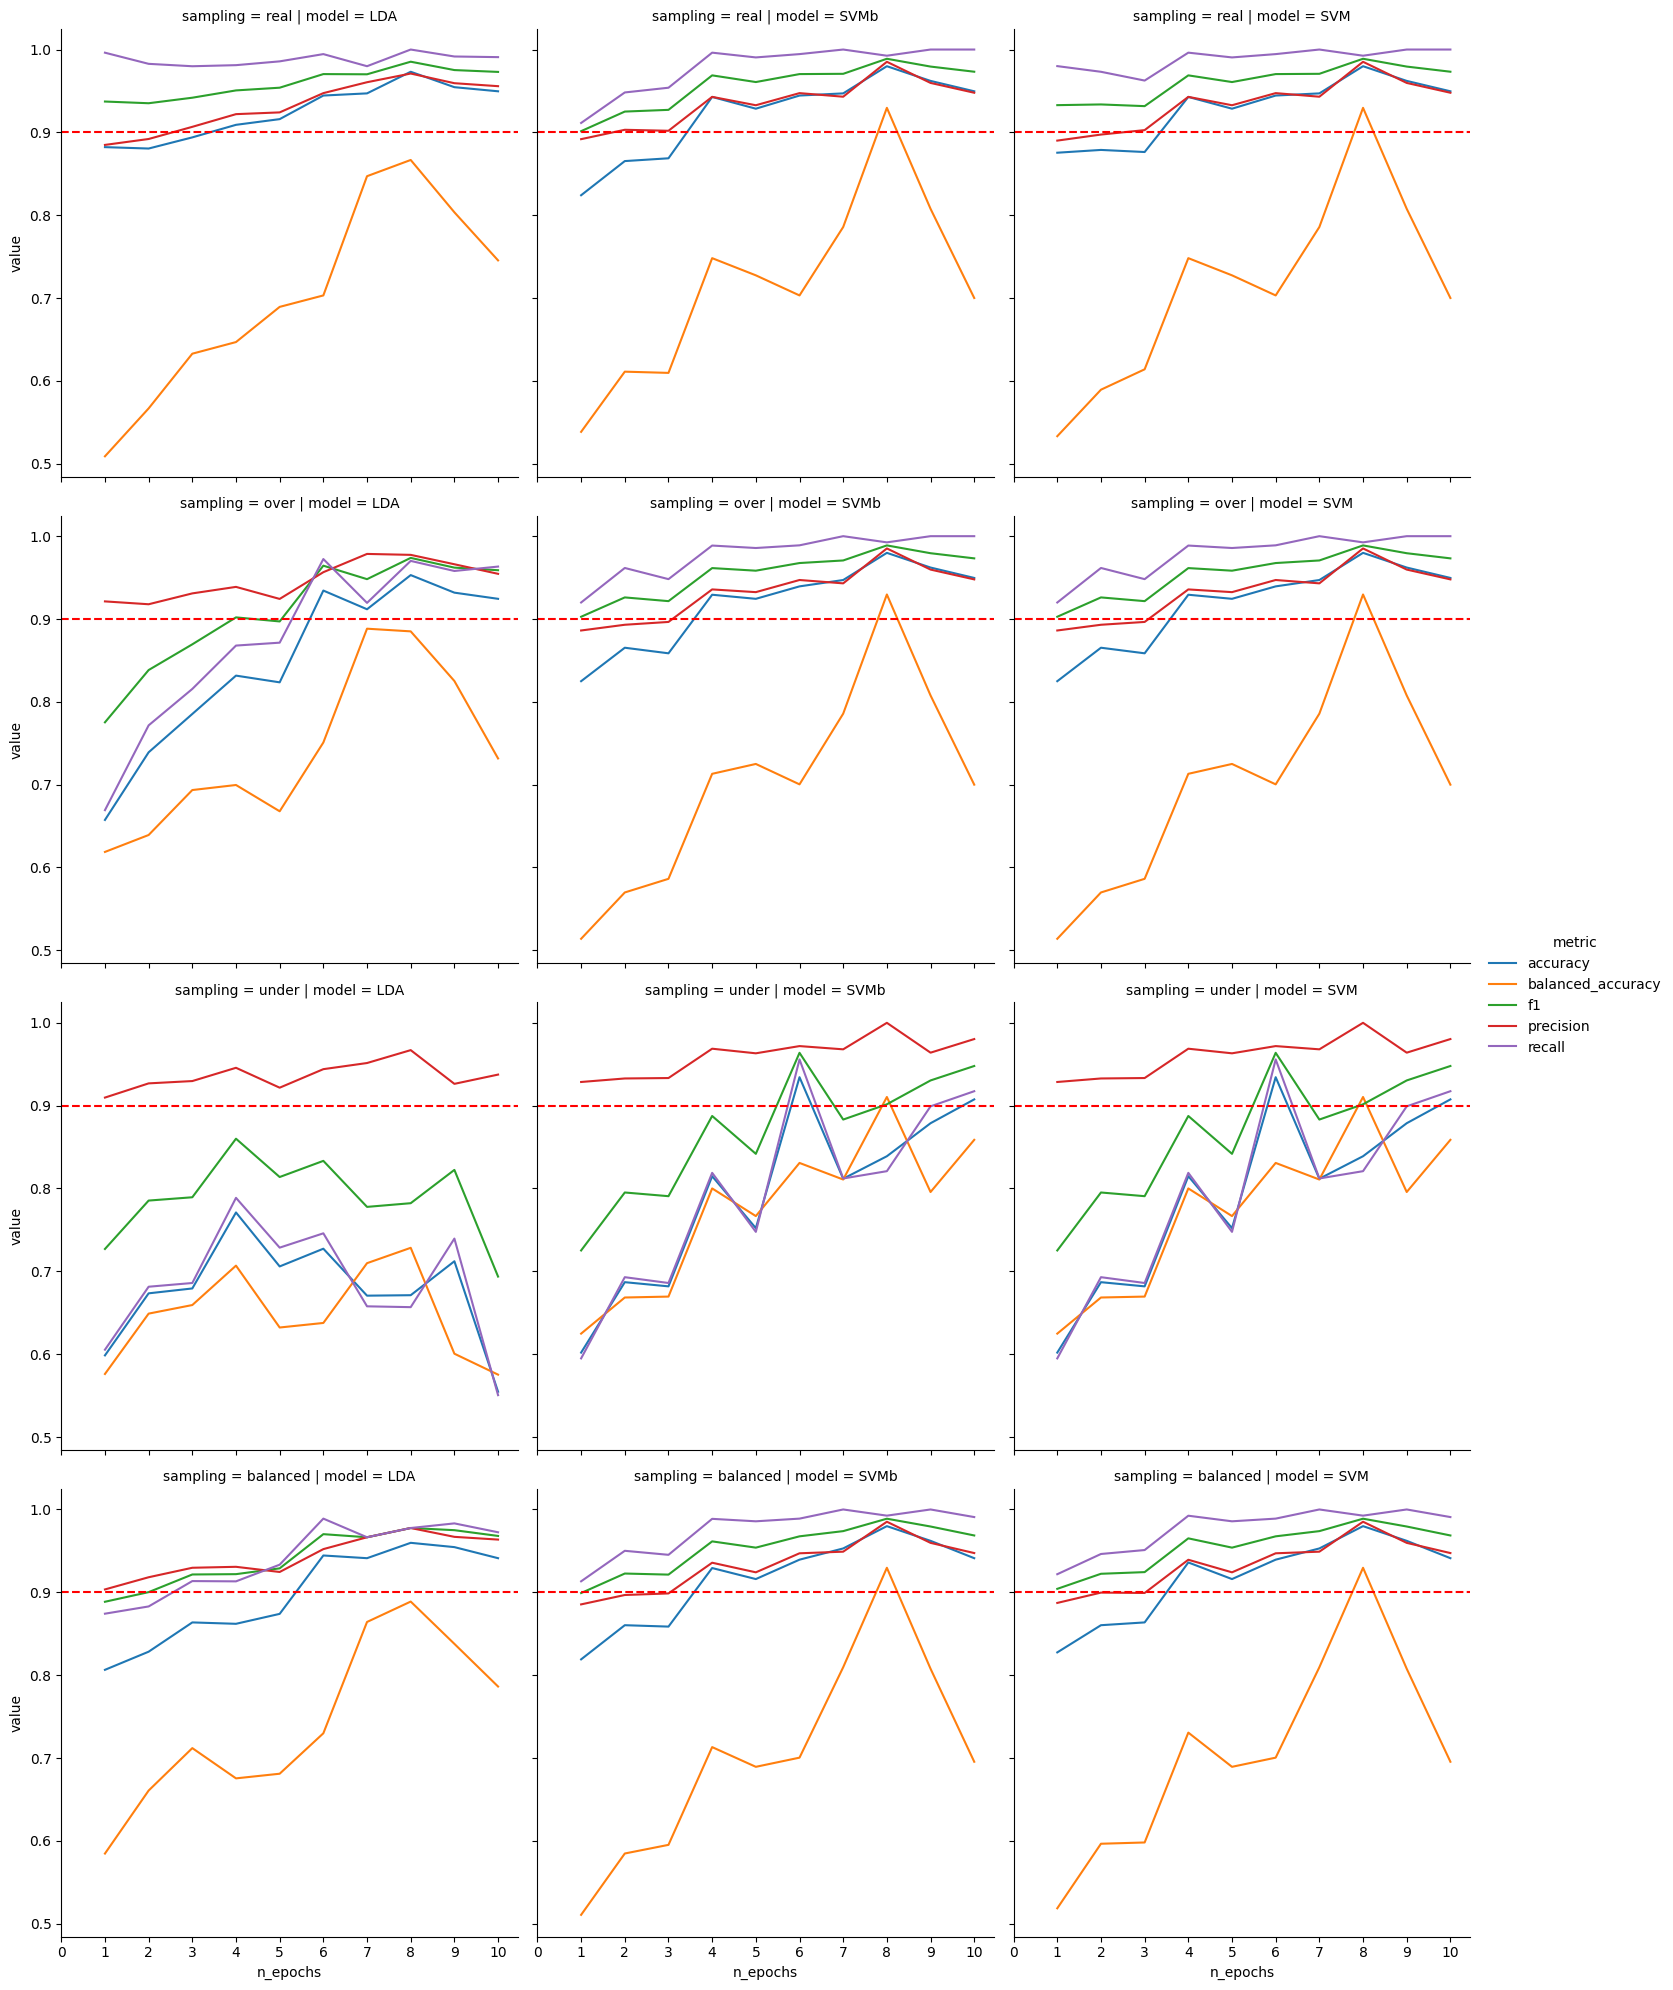

In [73]:
g = sns.relplot(df, x='n_epochs', y='value', hue='metric', col='model', row='sampling', kind='line')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    ax.set_xticks(np.arange(11))

Проведем аналогичные манипуляции, но для большего числа каналов

In [74]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(ch_set7)

In [75]:
ns = []
results = []

lda = LDA()
svm = SVC(kernel='rbf', C=10, random_state=42)
svmb = SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced')

for n in tqdm(range(1,11)):
    
    dataset.average(n)
    X = flatten(dataset.x.copy())
    y = dataset.y.copy()
    
    res = pipeline(X, y, lda, svmb, svm, models_names=['LDA', 'SVMb', 'SVM'],
                   scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'],
                   test_size=0.33, scaler=RobustScaler())
    ns.append(n)
    results.append(res)

100%|██████████| 10/10 [01:59<00:00, 11.92s/it]


In [78]:
dfs = []
for n, res in zip(ns, results):
    dfs.append(res.melt(id_vars=['model', 'sampling'], var_name='metric').assign(n_epochs=n))
df = pd.concat(dfs)

In [ ]:
# df.to_csv('n_epochs_comparsion2.csv')

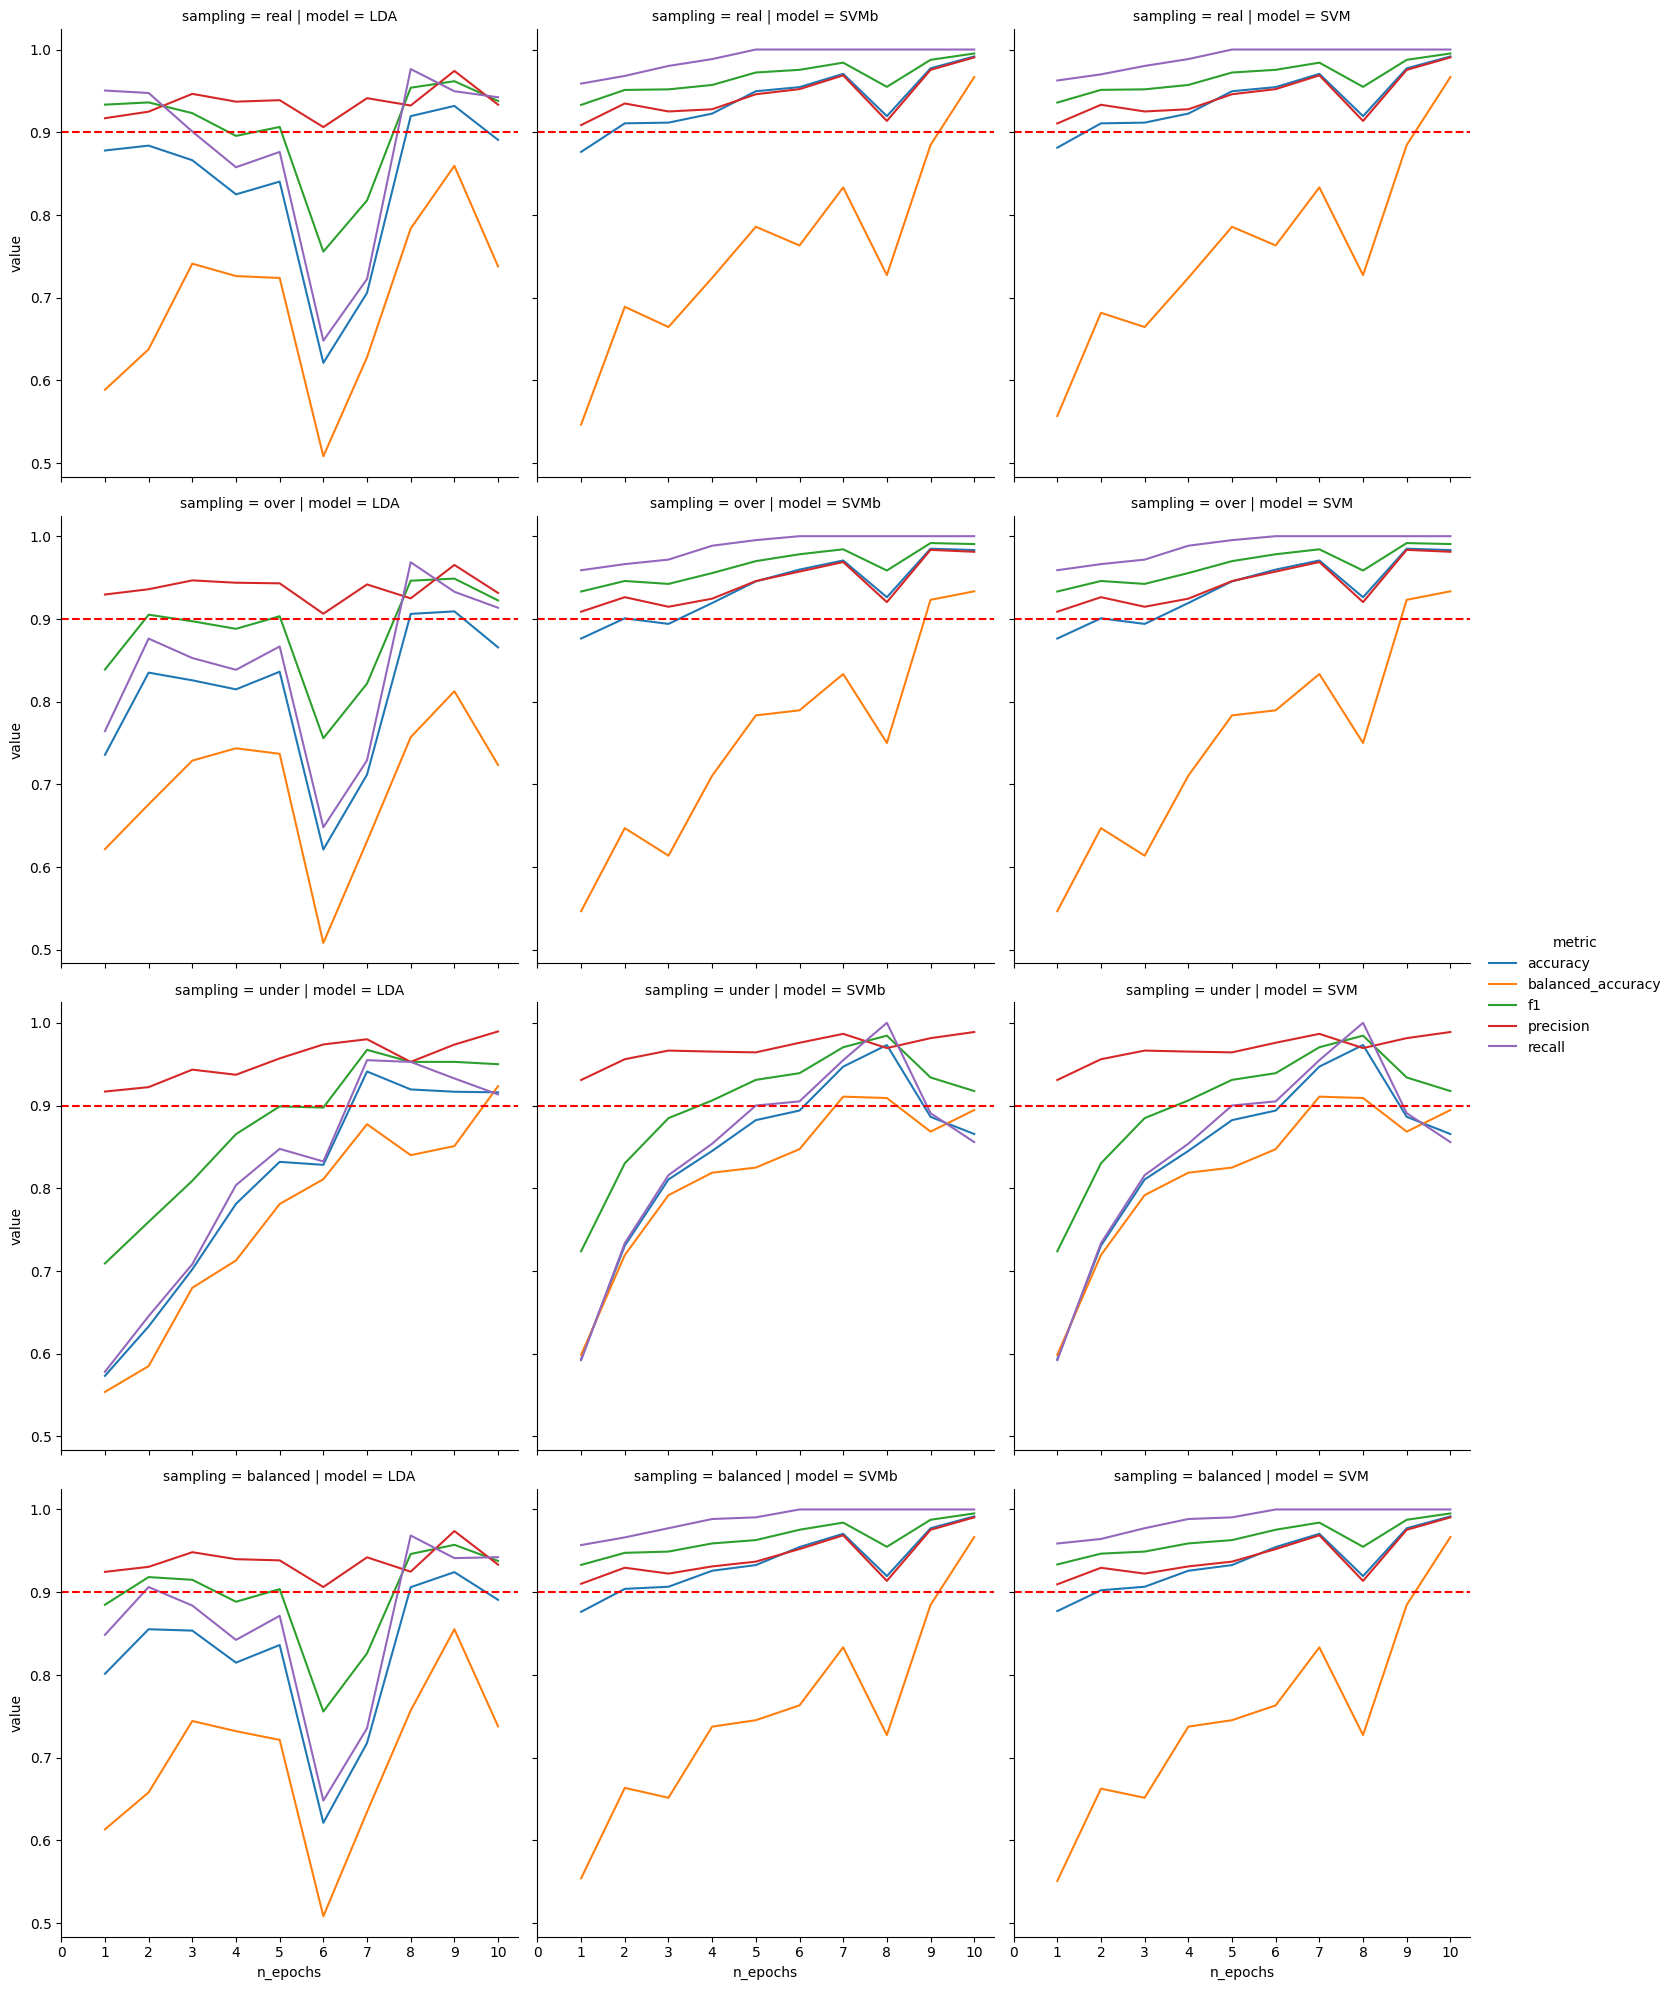

In [79]:
g = sns.relplot(df, x='n_epochs', y='value', hue='metric', col='model', row='sampling', kind='line')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    ax.set_xticks(np.arange(11))

## Влияние объема размера тренировочной выборки

In [80]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])

In [82]:
def separate_data(x, y, part):
    x_t = x[y==0]
    x_nt = x[y==1]
    x_t = x_t[:x_t.shape[0]//part]
    x_nt = x_nt[:x_nt.shape[0]//part]
    x_part = np.vstack([x_t, x_nt])
    y_part = np.hstack([np.zeros(x_t.shape[0]), np.ones(x_nt.shape[0])])
    
    return x_part, y_part

In [84]:
ns = []
results = []
X = flatten(dataset.x.copy())
y = dataset.y.copy()

lda = LDA()
svm = SVC(kernel='rbf', C=10, random_state=42)
svmb = SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced')

for n in tqdm(range(1,11)):
    x_part, y_part = separate_data(X, y, n)
 
    res = pipeline(X, y, lda, svmb, svm, models_names=['LDA', 'SVMb', 'SVM'],
                   scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'],
                   test_size=0.33, scaler=RobustScaler())
    ns.append(f'1/{n}')
    results.append(res)

100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


In [85]:
dfs = []
for n, res in zip(ns, results):
    dfs.append(res.melt(id_vars=['model', 'sampling'], var_name='metric').assign(part=n))
df = pd.concat(dfs)

In [86]:
# df.to_csv('n_part_of_data_comparsion2.csv')
# df = pd.read_csv('n_part_of_data_comparsion.csv', index_col=0)

In [87]:
df.head()

,model,sampling,metric,value,part
0,LDA,real,accuracy,0.885522,1/1
1,SVMb,real,accuracy,0.819024,1/1
2,SVM,real,accuracy,0.864478,1/1
3,LDA,over,accuracy,0.620370,1/1
4,SVMb,over,accuracy,0.824074,1/1


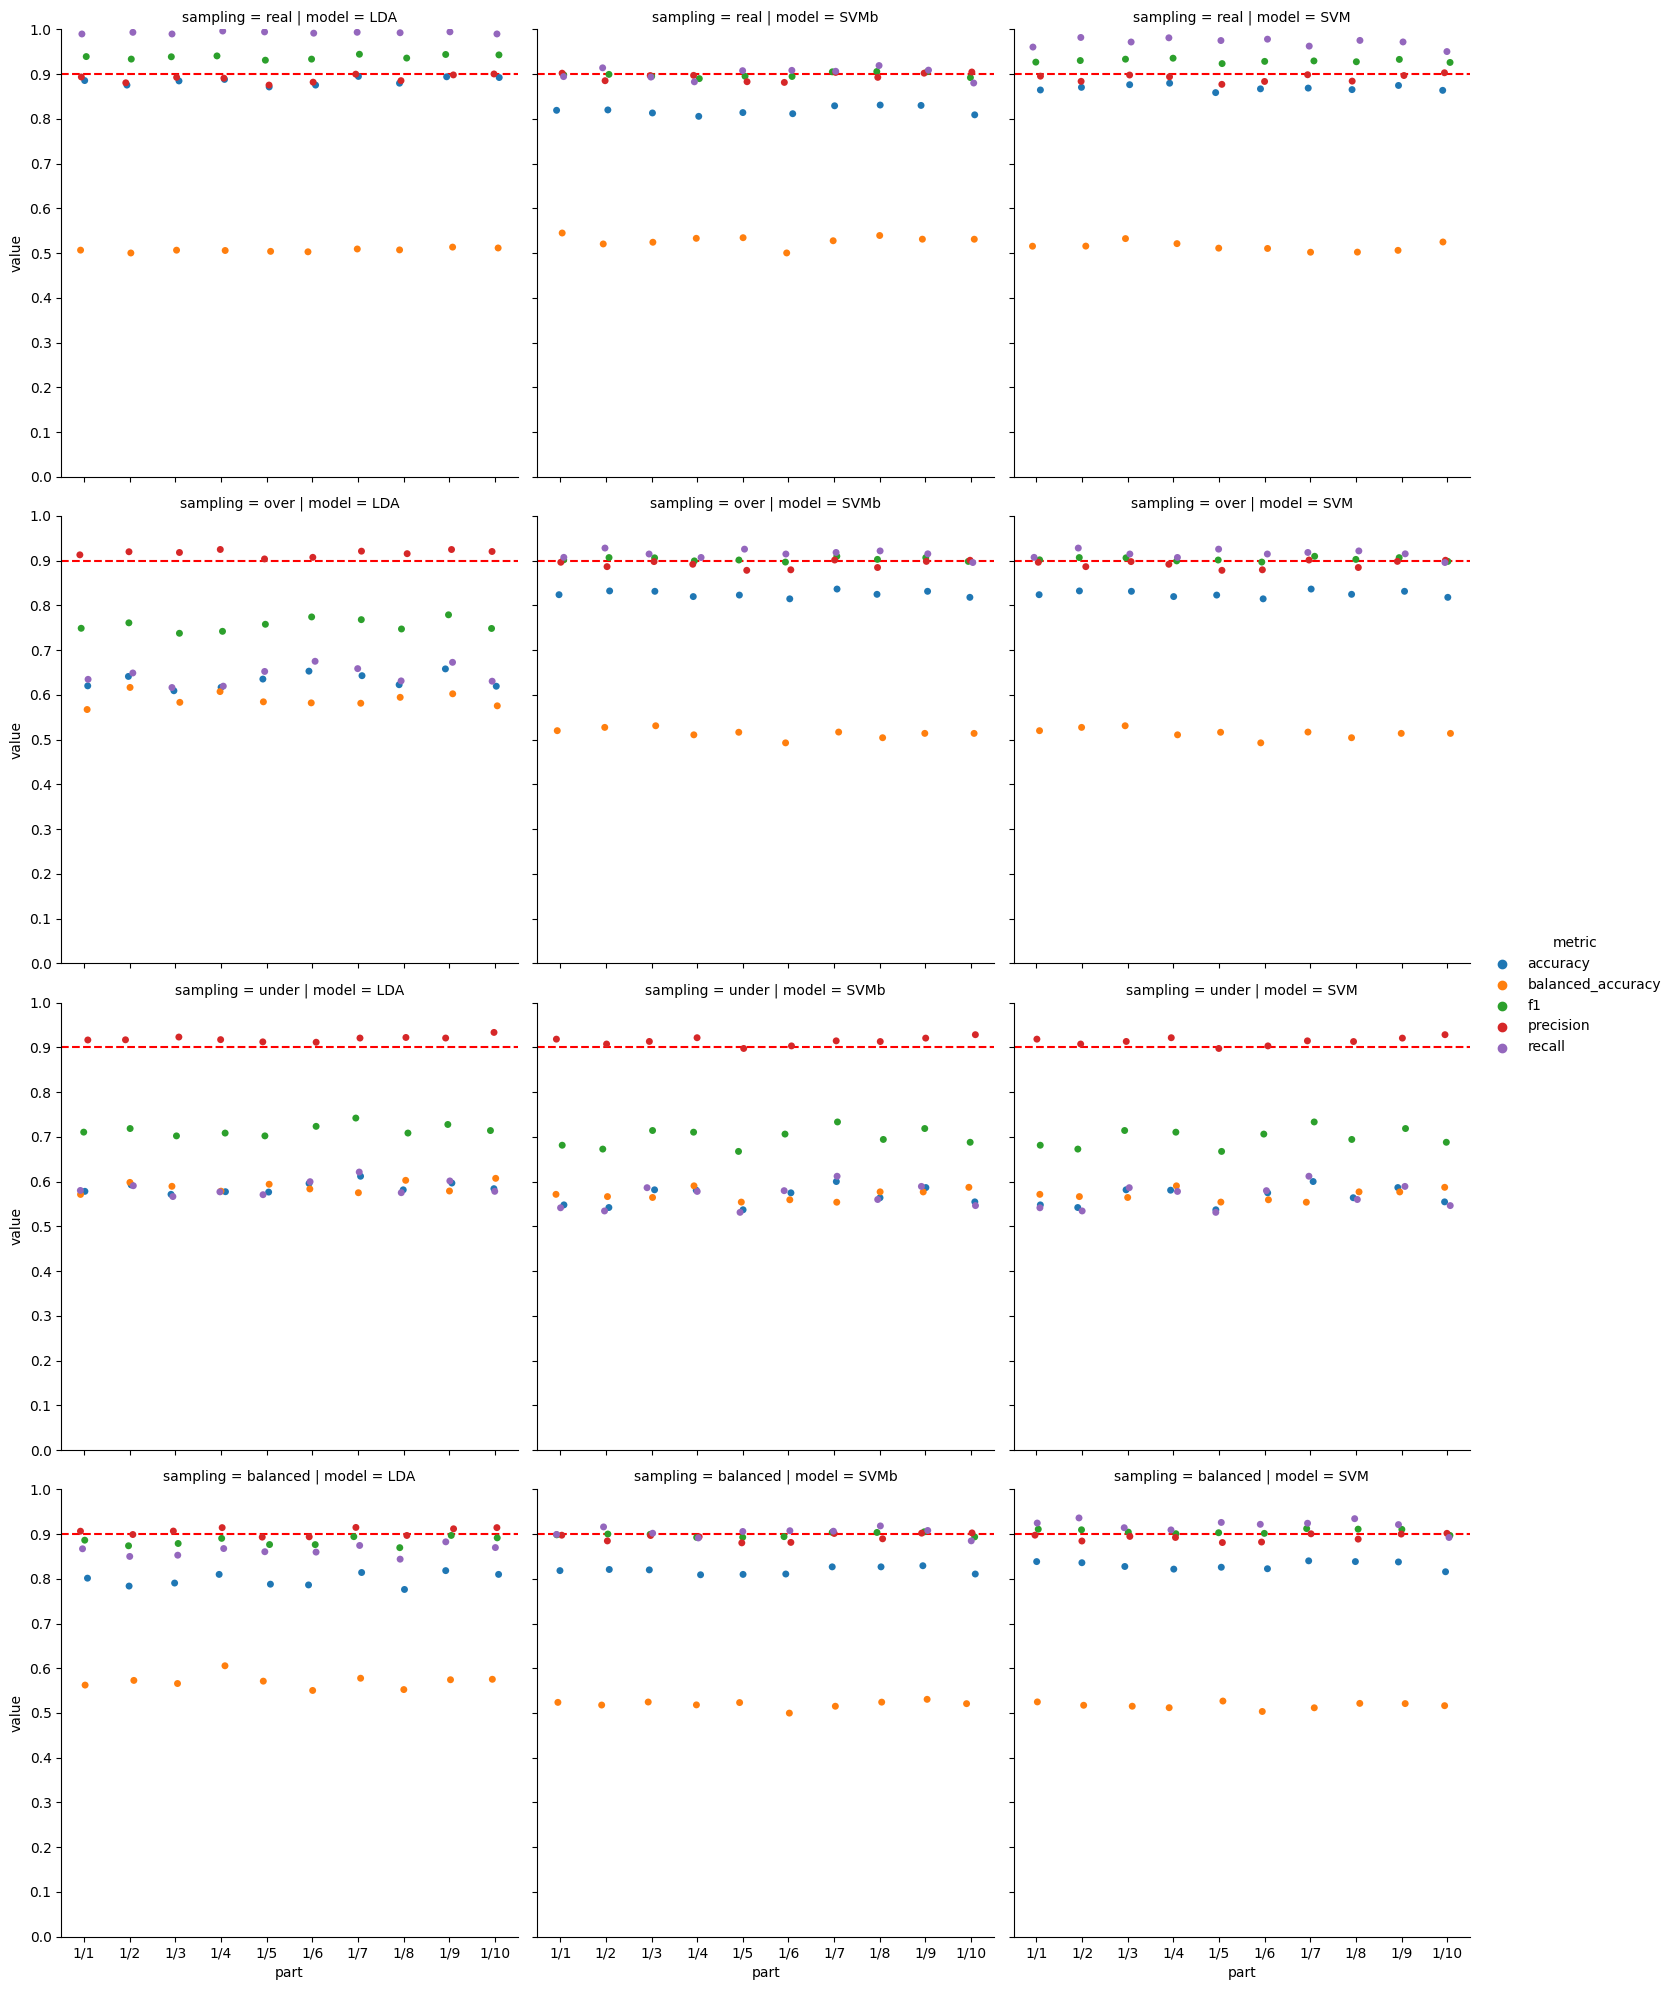

In [89]:
g = sns.catplot(df, x='part', y='value', hue='metric', col='model', row='sampling')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    ax.set_ylim((0,1))
    ax.set_yticks(np.arange(0,1.1,0.1))

## Проверим работу классификаторов на разных испытуемых и transfer learning

### Проверим работу классификаторов на всех испытуемых по отдельности

In [98]:
# Список кодов испытуемых
from pprint import pprint

files = os.listdir('./P300BCI_DataSet/')
files = list(filter(lambda x: x.endswith('.npy'), files))
subjects = list(set(map(lambda x:x.split('_')[0], files)))
subjects.sort()

pprint(subjects, compact=True)

['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'eab', 'en', 'fks', 'hra',
 'ieh', 'ik', 'irk', 'kka', 'kms', 'lv', 'mam', 'mb', 'mbm', 'mbu', 'mma', 'mp',
 'nb', 'nva', 'rae', 'rkv', 'sav', 'sdk', 'ski', 'smv', 'ss', 'tg', 'tp']


In [100]:
results = []

lda = LDA()
svm = SVC(kernel='rbf', C=10, random_state=42)
svmb = SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced')

for subj in tqdm(subjects):
    
    dataset = EEGDataset('./P300BCI_DataSet/', subj)
    dataset.pick_channels(['Pz'])
    
    X = flatten(dataset.x.copy())
    y = dataset.y.copy()
    
    res = pipeline(X, y, lda, svm, svmb, models_names=['LDA', 'SVM', 'SVMb'],
                   scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'],
                   scaler=RobustScaler(), test_size=0.33)
    
    results.append(res)
    

100%|██████████| 35/35 [08:17<00:00, 14.22s/it]


In [101]:
dfs = []
for subject, res in zip(subjects, results):
    dfs.append(res.melt(id_vars=['model', 'sampling'], var_name='metric').assign(subject=subject))
df = pd.concat(dfs)
df.head()

,model,sampling,metric,value,subject
0,LDA,real,accuracy,0.893098,ak
1,SVM,real,accuracy,0.883838,ak
2,SVMb,real,accuracy,0.848485,ak
3,LDA,over,accuracy,0.634680,ak
4,SVM,over,accuracy,0.841751,ak


In [102]:
# df.to_csv('all_subjects_tests2.csv')

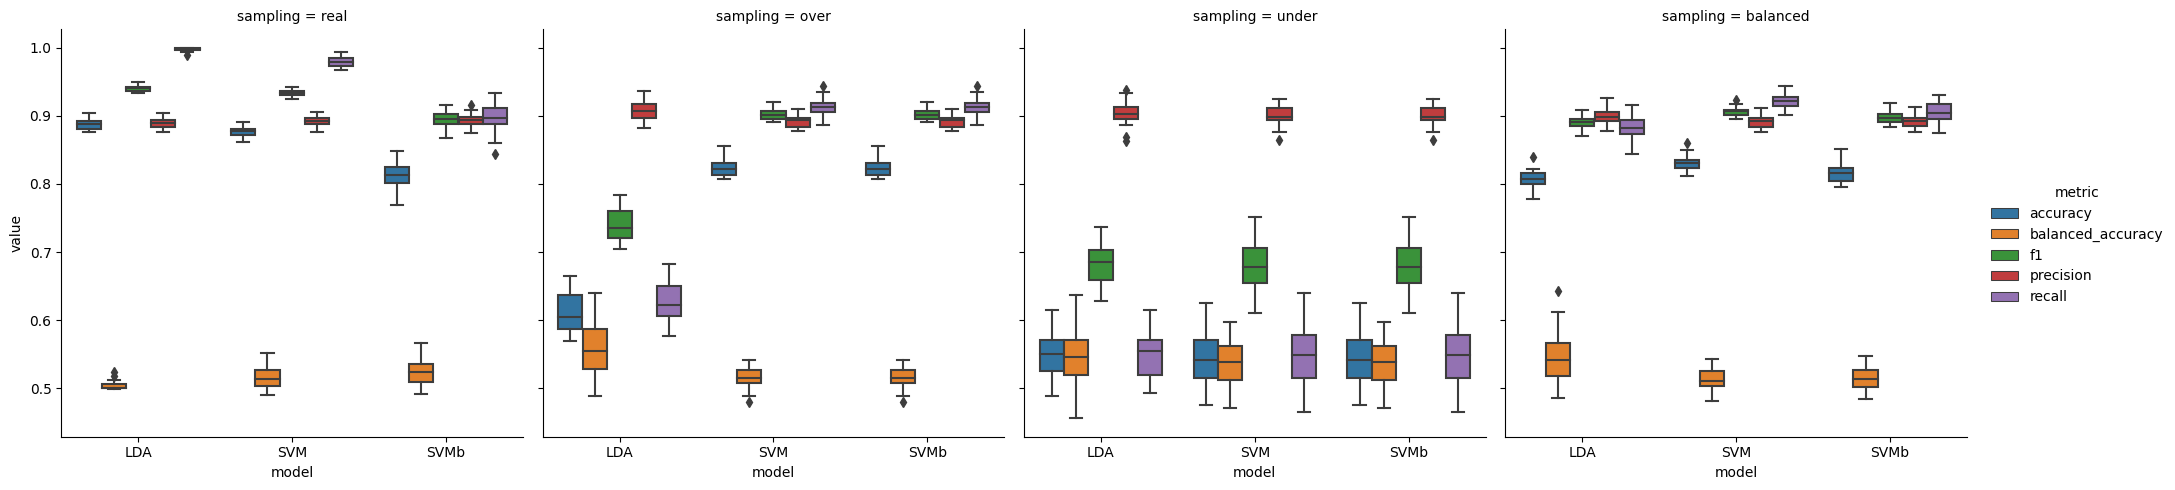

In [103]:
sns.catplot(df, x='model', y='value', col='sampling', hue='metric', kind='box')

Классификаторы показывают примерно равные показатели на разных испытуемых

### Опробуем способность моделей к transfer learning между испытуемыми

In [104]:
datasets = dict((k, v) for k, v in zip(subjects, [{} for _ in range(len(subjects))]))
for subj in tqdm(subjects):
    dataset = EEGDataset('./P300BCI_DataSet/', subj)
    dataset.pick_channels(['Pz'])
    X = flatten(dataset.x.copy())
    y = dataset.y.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    data = sampling(X=X_train, y=y_train)
    datasets[subj]['train_set'] = data
    datasets[subj]['x_test'] = X_test
    datasets[subj]['y_test'] = y_test
    

100%|██████████| 35/35 [03:01<00:00,  5.17s/it]


In [115]:
datasets['ik']['x_test'].shape

(1080, 301)

In [122]:
def test_loop(dataset:dict, res_dict:dict, scaler, subj_train, sampling, *models, models_names=None):
    
    for subj_test, test_set in tqdm(dataset.items(), leave=False):
        x_test = scaler.transform(test_set['x_test'])
        y_test = test_set['y_test']
        for name, model in zip(models_names, models):
            res_dict['train'].append(subj_train)
            res_dict['test'].append(subj_test)
            res_dict['model'].append(name)
            res_dict['sampling'].append(sampling)
            y_pred = model.predict(x_test)
            scores = get_scores(y_test, y_pred)
            res_dict = expand_dict(res_dict, scores)
            
def expand_dict(base, addon):
    for k, v in addon.items():
        if k in base.keys():
            base[k].append(v)
        else:
            base[k]=[v]
    return base        


In [123]:
res_dict = {'train':[], 'test':[], 'models':[], 'sampling':[]}

for subj_train, dataset in tqdm(datasets.items()):
    
    train_set = dataset['train_set']
    
    for sampl, data in train_set.items():
        X_train = data['x']
        y_train = data['y']
        
        scaler = RobustScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        
        lda = LDA().fit(X_train, y_train)
        svm = SVC(kernel='rbf', C=10, random_state=42).fit(X_train, y_train)
        
        test_loop(datasets, res_dict, scaler, subj_train, sampl, lda, svm, models_names=['LDA', 'SVM'])

100%|██████████| 35/35 [23:26<00:00, 40.19s/it]


In [145]:
res = pd.DataFrame(res_dict)
res.rename(columns={'models':'model'}, inplace=True)
res = res.melt(id_vars=['train', 'test', 'model', 'sampling'], var_name='metric')
res_lda = res[res.model=='LDA']
res_svm = res[res.model=='SVM']
res_svm.head()

,train,test,model,sampling,metric,value
1,ak,ak,SVM,real,accuracy,0.862963
3,ak,as,SVM,real,accuracy,0.868297
5,ak,az,SVM,real,accuracy,0.873723
7,ak,dad,SVM,real,accuracy,0.854749
9,ak,dkv,SVM,real,accuracy,0.864815


In [125]:
# res.to_csv('all_vs_all_classification.csv')

In [156]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d,**kwargs)

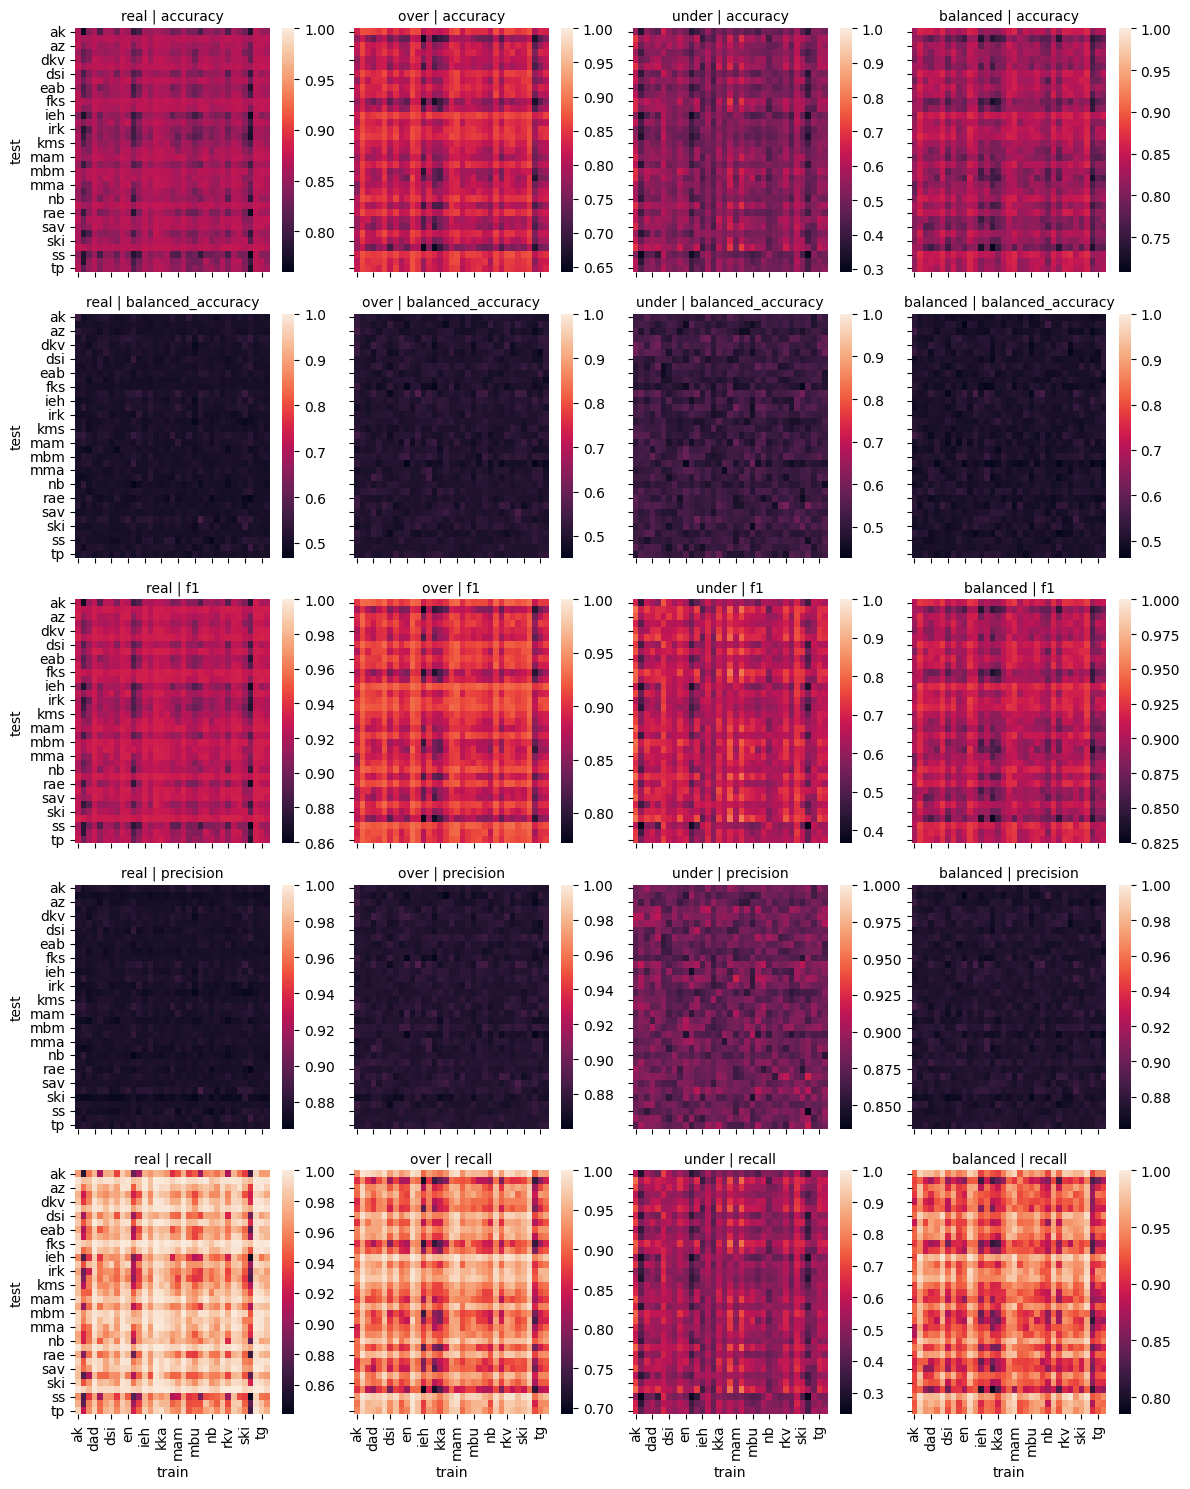

In [217]:
g = sns.FacetGrid(res_svm, col='sampling', row='metric')
g.set_titles('{col_name} | {row_name}')
g.map_dataframe(draw_heatmap, 'train', 'test', 'value', vmax=1)

Перенос весов в случае классических классификаторов (без усреднения эпох, 1 канал) невозможен

### Кросс валидация по типу "Один против всех"

In [158]:
from pprint import pprint

dataset = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, transform=Flatten(0))
dataset.pick_channels(['Pz'])
pprint(dataset.subjects, compact=True)

['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'eab', 'en', 'fks', 'hra',
 'ieh', 'ik', 'irk', 'kka', 'kms', 'lv', 'mam', 'mb', 'mbm', 'mbu', 'mma', 'mp',
 'nb', 'nva', 'rae', 'rkv', 'sav', 'sdk', 'ski', 'smv', 'ss', 'tg', 'tp']


In [161]:
splitter = One_vs_all(dataset)
n = 0
for train_set, test_set in splitter:
    if n==5: break
    print(test_set.picked_subjects, len(train_set))
    n+=1
    

['ak'] 121984
['as'] 122042
['az'] 121995
['dad'] 122007
['dkv'] 121985


In [179]:
dataset = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, cache_dir_name='eeg_cache_compressed', subjects=['ik'], transform=Flatten(0))
dataset.pick_channels(['Pz'])

In [180]:
dataset[0][0].shape

torch.Size([151])

target


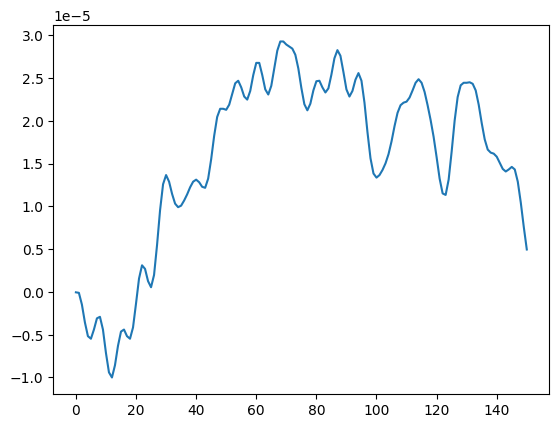

In [215]:
# i = -2
# print(dataset.labels_info[int(dataset[i][1])])
plt.plot(dataset[])

In [245]:
3600/np.array([400, 3200])

array([9.   , 1.125])

In [269]:
from torch.utils.data import WeightedRandomSampler
train_set, test_set = my_train_test_split(dataset, size=[0.7, 0.3])
sampler = WeightedRandomSampler([0.5, 0.5], len(train_set))
train_loader = DataLoader(train_set, batch_size=128, sampler=sampler)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [270]:
svm = SVC(C=10, kernel='rbf', random_state=42)
lda = LDA()
for X, y in tqdm(train_loader):
    svm.fit(X, y)
    # lda.fit(X, y)

100%|██████████| 20/20 [00:01<00:00, 19.35it/s]


In [271]:
# result = {'model':[]}
# for X, y_test in tqdm(test_loader):
#     for model in zip([svm, lda], ['SVM', 'LDA']):
#         y_pred = model.predict(X)
#         score = get_scores(y_test, y_pred)
#         expand_dict(result, score)
X, y = next(iter(test_loader))
y_pred = svm.predict(X)
get_scores(y, y_pred)

{'accuracy': 0.296875,
 'balanced_accuracy': 0.5404682274247492,
 'f1': 0.375,
 'precision': 0.9310344827586207,
 'recall': 0.23478260869565218}

In [64]:
subjects = dataset.available_subjects.copy()
dataset.pick_channels(['Pz'])

In [80]:
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

subjects_list = []
models = []
accuracy = []
balanced_accuracy = []
f1 = []
f1_weighted = []
subject = 'ak'
train_set = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, subjects=[s for s in subjects if s != subject])
test_set = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, subjects=[subject])
train_loader = DataLoader(train_set, 128, True)
test_loader = DataLoader(test_set, 128, shuffle=False)
lda = LDA()
svm = SVC(C=10, kernel='rbf', random_state=42)
n = 0
for batch, y_train in train_loader:
    x_train = flatten(batch)
    lda.fit(x_train, y_train)
    svm.fit(x_train, y_train)
    clear_output()
    n+=1
    print(f'{n}/{len(train_loader)} done')
    
for name, model in zip(['LDA', 'SVM'], [lda, svm]):
    subjects_list.append(subject)
    models.append(name)
    accs = []
    acbs = []
    f1s = []
    f1ws = []
    for x_test, y_test in test_loader:
        x_test = flatten(x_test)
        y_pred = model.predict(x_test)
        accs.append(accuracy_score(y_test, y_pred))
        acbs.append(balanced_accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        f1ws.append(f1_score(y_test, y_pred, average='weighted'))
    accuracy.append(np.array(accs).mean())
    balanced_accuracy.append(np.array(acbs).mean())
    f1.append(np.array(f1s).mean())
    f1_weighted.append(np.array(f1ws).mean())

953/953 done


In [81]:
accuracy

[0.8246228448275862, 0.8865840517241379]

# Тестирование без оверсемпла

In [122]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [109]:
X = np.vstack([X[y==1], X[y==0].repeat(6, axis=0)])
y = np.hstack([y[y==1], y[y==0].repeat(6)])

In [123]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_train = np.vstack([x_train[y_train==1], x_train[y_train==0].repeat(6, axis=0)])
y_train = np.hstack([y_train[y_train==1], y_train[y_train==0].repeat(6)])
# over = SMOTE(sampling_strategy=0.5)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# pipe = Pipeline(steps=steps)
# x_train, y_train = pipe.fit_resample(x_train, y_train)
# X, y, X_down, y_down, X_over, y_over = sampling(X=x_train, y=y_train, report=True)
# data = {'real':{'x': X,
#                 'y': y},
#         'downsample':{'x': X_down,
#                       'y': y_down},
#         'oversample':{'x': X_over,
#                       'y': y_over}}

In [103]:
c = Counter(y_train)
print(c)

Counter({1: 2255, 0: 1584})


In [106]:
n_target = c[0]
x_test = np.vstack([x_test[y_test==0], x_test[y_test==1][:n_target]])
y_test = np.hstack([y_test[y_test==0], y_test[y_test==1][:n_target]])

In [120]:
svm = SVC(random_state=42)
svm.fit(x_train, y_train)

SVC(random_state=42)

In [121]:
y_pred = svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('accuracy_balanced:', balanced_accuracy_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

accuracy: 0.7888888888888889
accuracy_balanced: 0.5514183041516936
f1: 0.8782051282051282


In [125]:
from sklearn.model_selection import GridSearchCV
svc = SVC(random_state=42)
params = {'C':(1e-3, 1e-2, 1e-1, 1, 10, 100),
          'kernel':('linear', 'poly', 'rbf', 'sigmoid')}
search = GridSearchCV(svc, params, scoring='balanced_accuracy')

search.fit(x_train, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': (0.001, 0.01, 0.1, 1, 10, 100),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='balanced_accuracy')

In [126]:
search.best_params_

{'C': 0.1, 'kernel': 'rbf'}

In [128]:
search.best_score_

0.5741334306323502

In [ ]:
res = search.cv_results_
df = pd.DataFrame({'kernel':res['param_kernel'].data,
                   'C':res['param_C'].data,
                   'accuracy':res['mean_test_accuracy'],
                   'f1':res['mean_test_f1']})

In [ ]:
df.C = df.C.astype(dtype=str)
df.C.dtype

dtype('O')

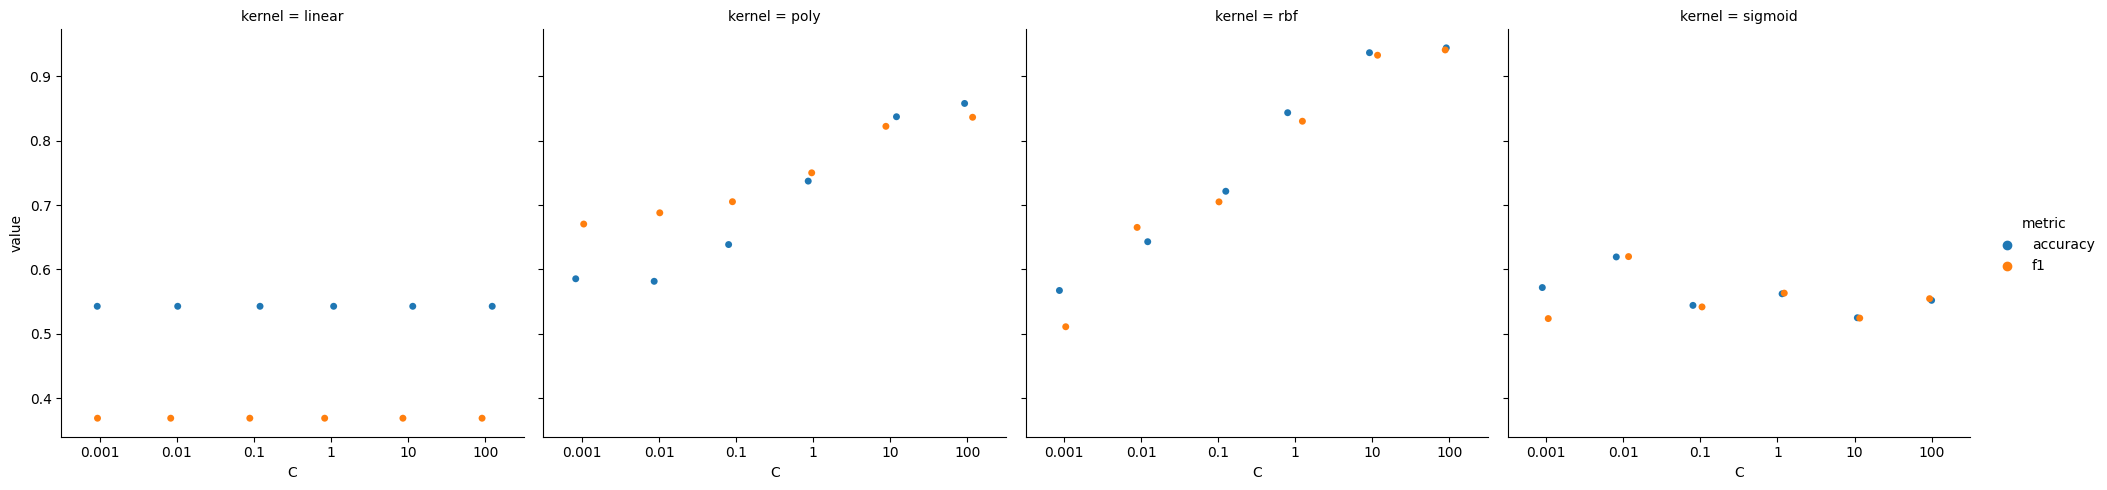

In [ ]:
g = sns.catplot(df, x='C', y='value', col='kernel', hue='metric')